In [1]:
import os

curr_dir = os.path.split(os.getcwd())[1]
if curr_dir != "irl-environment-design":
    os.chdir("..")

In [2]:
import numpy as np

from src.utils.make_environment import (
    transition_matrix,
    Environment,
    insert_walls_into_T,
)

from src.utils.constants import ParamTuple

np.set_printoptions(linewidth=160, precision=2)

from src.utils.environment_design import EnvironmentDesign

from src.utils.inference.posterior import PosteriorInference

/home/paul/.local/lib/python3.10/site-packages/numba/core/decorators.py:282: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


### Create Environment

In [3]:
# 0. Setup
## 0.2 Setup the environment
N, M = 7,7

# TODO describe world
agent_R = np.zeros((N, M))
agent_R[N-1, 0] = 1
agent_R[N-1, M-1] = 3



# Start by making the agent we want to learn the policy of
agent_p = 0.85
agent_gamma = 0.65
p_true=1

agent_R = agent_R.flatten()
goal_states = np.where(agent_R != 0)[0]

true_params = ParamTuple(agent_p, agent_gamma, agent_R)

wall_states = [14]

T_true = transition_matrix(N, M, p=p_true, absorbing_states=goal_states)
T_True = insert_walls_into_T(T=T_true, wall_indices=wall_states)

big_small = Environment(
    N=N,
    M=M,
    T_true=T_true,
    wall_states=wall_states,
    R_true=agent_R,
    start_state=0,
    n_walls=None,
    goal_states=goal_states
)

### Environment Design

In [4]:
env_design = EnvironmentDesign(base_environment=big_small, user_params=true_params, learn_what = "gamma, T")

In [5]:
candidate_environments_args = {}
# candidate_environments_args["n_environments"] = 50
candidate_environments_args["generate_how"] = "entropy_BM"
# candidate_environments_args["n_walls"] = 5


env_design.run_n_episodes(n_episodes=25,
                          bayesian_regret_how="value",
                          candidate_environments_args=candidate_environments_args)

env_design.save("big_small")

Started episode 0.
Finished episode 0.
Started episode 1.
Mean Parameters: ParamTuple(p=0.7315122367543453, gamma=0.6928401720963351, R=None)


/home/paul/Desktop/Uni/classes/CS282R/irl-environment-design/src/utils/make_candidate_environments.py:137: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  R = torch.tensor(R_init, dtype=torch.float32)


Learned Reward Function that maximizes Entropy. Reward function:  tensor([ 0.0674,  0.1336,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0618,
         0.1361,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1234,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1343,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.1299,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0699,  0.1296,  0.1273,  0.1280,  0.1350,
         0.1579,  0.0000,  1.0000, -0.0691,  0.0000,  0.0000,  0.0000,  0.1949,
         3.0000])
Finished episode 1.
Started episode 2.
Mean Parameters: ParamTuple(p=0.7596382284854429, gamma=0.7132847958151161, R=None)
Learned Reward Function that maximizes Entropy. Reward function:  tensor([ 7.2163e-02,  1.4329e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         0.0000e+00,  0.0000e+00, -6.6415e-02,  1.4552e-01,  0.0000e+00,
         0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,
         1.3267e-01,  0.0000

### Inference - load observations and initialize posterior inference class.

In [6]:
import pickle

experiment_name = os.path.join("checkpoints", "big_small", "18.04.2024", "16:28:40")

def load_file(file_name):
    with open(file_name, 'rb') as file:
        data = pickle.load(file)
    return data

# Example usage
file_name = experiment_name
big_small_experiment = load_file(file_name)

In [7]:
obs = big_small_experiment["all_observations"][7]

In [8]:
obs[0].R_true

tensor([ 0.0000,  0.0857,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000, -0.0806,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0000,
         0.0000,  0.0000,  0.0000,  0.0000,  0.0000,  0.0845,  0.0912,  0.1076,
         0.1297,  0.0000,  1.0000, -0.0954,  0.0000,  0.0000,  0.0000,  0.1526,
         3.0000])

In [9]:
pos_inference = PosteriorInference(expert_trajectories=[big_small_experiment["all_observations"][7]],
                                    resolution = 15,
                                    min_gamma = 0.5,
                                    max_gamma = 0.99,
                                    min_p = 0.5,
                                    max_p = 0.99)

### Calculate Posterior Distribution.

In [10]:
pos_inference.calculate_posterior(num_episodes=1)

Calculate distribution of episode 0, e.g. the prior distribution.
Calculate distribution of episode 1.


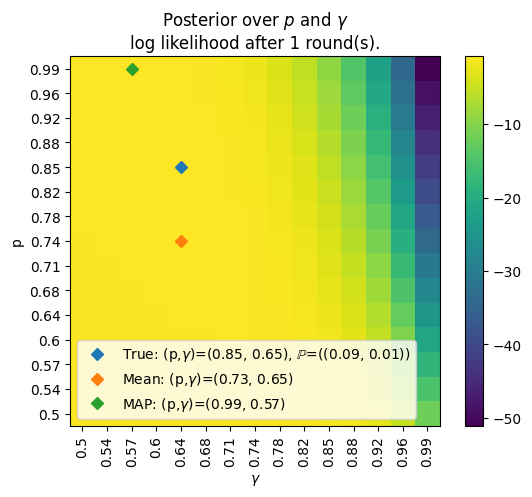

In [11]:
pos_inference.plot_posterior(episode=1, param_values=true_params)

### Make inference.

In [12]:
pos_inference.plot_statistics_over_time(episode=4, true_params=true_params)

AssertionError: Posterior Distribution for this episode does not exist yet. Only the following episodes exist: dict_keys(['episode=0', 'episode=1'])

In [ ]:
pos_inference.plot_posterior(episode=10, true_params=true_params)